# Frequency and power distribution comparison between 1st and 5th hour of POST 
- both measures were calculated using wavelet transform
- Runs slow, maybe adding parallel loop for wavelet calculation will help, or move to hilbert amplitude which will be lot faster.

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import TimeFrequency
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sd_sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
)
nsd_sessions = (
    subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat

rpl_power = pd.DataFrame()
rpl_freq_dist = pd.DataFrame()
for grp, sessions in zip(["sd", "nsd"], [sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        print(grp,sub)
        post = sess.paradigm["post"].flatten()
        # sd = sess.paradigm["sd"].flatten()
        sd = [post[0], post[0] + 5 * 3600]
        channels = sess.ripple.metadata["channels"]

        signal = sess.eegfile.get_signal(channels, 1800, 3600)
        hilbert_stat = hilbert_ampltiude_stat(
            signal.traces, freq_band=(150, 250), fs=1250, statistic="median"
        )

        channel = channels[np.argmax(hilbert_stat)]

        freqs = np.arange(130, 250, 2)
        rpls_1h = sess.ripple.time_slice(sd[0], sd[0] + 3600).set_labels("1st")
        rpls_5h = sess.ripple.time_slice(sd[0] + 4 * 3600, sd[1]).set_labels("5th")
        rpls_6h = sess.ripple.time_slice(sd[1], sd[1] + 3600).set_labels("6th")

        rpls_comb = rpls_1h + rpls_5h + rpls_6h
        max_power, freq_dist = [], []
        for start, stop in zip(rpls_comb.starts, rpls_comb.stops):
            signal = sess.eegfile.get_signal(channel, start, stop)
            wvlt = TimeFrequency(
                signal=signal, freqs=freqs, method="wavelet", ncycles=7
            )
            wvlt_mean = wvlt.mean_power()
            max_power.append(np.max(wvlt_mean))
            freq_dist.append(np.mean(wvlt.traces, axis=1))

        df1 = pd.DataFrame(
            {
                "max_power": np.array(max_power),
                "hour": rpls_comb.labels,
                "sub": sub,
                "grp": grp,
            }
        )
        df2 = pd.DataFrame(np.asarray(freq_dist), columns=freqs)
        df2["hour"] = rpls_comb.labels
        df2["sub"] = sub
        df2["grp"] = grp
        df2 = pd.melt(
            df2,
            id_vars=["hour", "sub", "grp"],
            value_vars=freqs,
            var_name=["freq"],
            value_name="freq_power",
            ignore_index=True,
        )

        rpl_power = rpl_power.append(df1).reset_index(drop=True)
        rpl_freq_dist = rpl_freq_dist.append(df2).reset_index(drop=True)


## Frequency distribution plot

In [ ]:
%matplotlib widget
import seaborn as sns

dist = sns.relplot(
    data=rpl_freq_dist,
    x="freq",
    y='freq_power',
    hue="hour",
    ci=None,
    kind='line',
    row="sub",
    col='grp',
    height=1.5,
    aspect=2,
    lw=1,
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5.pdf')

## Power distribution plot

In [ ]:
%matplotlib widget
from neuropy import plotting
import seaborn as sns

dist = sns.displot(
    data=rpl_power,
    x="max_power",
    hue="hour",
    stat="probability",
    # binrange=(0, 140),
    kind='hist',
    row="sub",
    col='grp',
    cumulative=False,
    # ax=ax,
    element="step",
    fill=False,
    common_norm=False,
    height=1.5,
    aspect=2,
    lw=1,
    # alpha=0.8,
    palette=['#5cc0eb','#faa49d','#05d69e'],
    
)

# dist.figure.savefig(subjects.figpath_sd/'ripple_power_dist_Zt1_vs_Zt5_vs_Zt6.pdf')


# Spike triggered raster plot w.r.t ripples during sleep deprivation for individual neurons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subjects

sessions = subjects.sd.ratSday3

In [ ]:
for sub,sess in enumerate(sessions):
    sd = sess.paradigm['sd']
    rpls = sess.ripple.time_slice(sd[0],sd[1])
    

# Total/mean ripple duration from first hour to last hour SD

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.signal_process import TimeFrequency
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [ ]:
rpl_duration = pd.DataFrame()
for sub, sess in enumerate(sessions):

    post = sess.paradigm["post"].flatten()
    rpls_1h = sess.ripple.time_slice(post[0], post[0] + 1*3600).durations.sum()
    rpls_5h = sess.ripple.time_slice(
        post[0] + 4* 3600, post[0] + 5 * 3600
    ).durations.sum()

    rpl_duration = rpl_duration.append(
        pd.DataFrame(
            {"epoch": ["1h", "5h"], "rpl_duration": [rpls_1h, rpls_5h], "grp": sess.tag,'sub':sub}
        )
    ).reset_index(drop=True)


In [ ]:
%matplotlib widget
import seaborn as sns

# fig,axs = plt.subplots(1,2)
# for i,grp in enumerate(['sd','nsd']):
#     data = rpl_duration[rpl_duration['grp']==grp]
#     ax = axs[0,i]
#     sns.stripplot()
#     sns.catplot(data=rpl_duration,x='epoch',y='rpl_duration',col='grp',kind='strip',jitter=0)
g=sns.relplot(
    data=rpl_duration,
    x="epoch",
    y="rpl_duration",
    hue="sub",
    col="grp",
    # row='rpl_duration',
    kind="line",
    marker="o",
    palette=['gray']*len(sessions),
)

[ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]

# Interneuron categorization based on firing rate around ripples start
- using CCG algorithm

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)


In [ ]:
acgs =[]
bin_size = 0.01
window_size = 0.2
n_bins = int(window_size//bin_size)
for sub,sess in enumerate(sessions):
    ripple = sess.ripple.to_dataframe().peaktime.values
    neurons = sess.neurons.get_neuron_type('inter') 
    for s in neurons.spiketrains:
        combined_s = np.concatenate((s,ripple))
        combined_id = np.concatenate((np.ones(len(s)),2*np.ones(len(ripple)))).astype('int')
        sort_ind = np.argsort(combined_s)
        acg = correlograms(combined_s[sort_ind],combined_id[sort_ind],sample_rate=30000,bin_size=bin_size,window_size=window_size)
        acgs.append(acg[0,1,:])

acgs = np.asarray(acgs)
t_bin = np.linspace(-n_bins//2,n_bins//2,acgs.shape[1])
data = pd.DataFrame(stats.zscore(acgs,axis=1),columns=t_bin)
data['neuron'] = np.arange(acgs.shape[0])
data = pd.melt(
    data,
    id_vars=["neuron"],
    value_vars=t_bin,
    var_name=['time'],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
import seaborn as sns

_,axs = plt.subplots(10,9,sharex=True,sharey=True)
axs = axs.reshape(-1)

acgs_norm = acgs/np.sum(acgs,axis=1,keepdims=True)

for i,a in enumerate(acgs_norm):

    axs[i].fill_between(t_bin,0,a)


# from neuropy.core import Ratemap

# rmap = Ratemap(acgs,np.arange(52),neuron_ids=np.arange(acgs.shape[0]))
# plotting.plot_ratemap(rmap,normalize_tuning_curve=True,pad=2)

# sns.catplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='bar')
# sns.relplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='line')

# Interneurons categorization based on ripple modulation
- The method here is similar to Diba et.al. 2014

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)

In [337]:
from sklearn.cluster import KMeans

frate_around_rpl, frate_session_all, grp_info = [], [], []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()
    frate_session_all.append(
        neurons.time_slice(post[0], post[0] + 9 * 3600)
        .get_binned_spiketrains(5 * 60)
        .firing_rate
    )
    grp_info.extend([sess.tag] * n_neurons)

    counts_slice = []
    for s in range(3):
        rpls = ripples[s::3]
        n_rpls = len(rpls)
        rpl_start = rpls.start.values.reshape(-1, 1)
        rpl_peak = rpls.peaktime.values.reshape(-1, 1)
        rpl_stop = rpls.stop.values.reshape(-1, 1)

        binsize = np.hstack((rpl_peak - rpl_start, rpl_stop - rpl_peak)) / 4
        binsize = np.repeat(binsize, (8, 9), axis=1)

        bins = np.arange(-8, 9)[np.newaxis, :]

        rpl_bins = rpl_peak + binsize * bins

        # inorder to avoid overlapping bins the divided into four parts
        counts_around_rpl = []
        for i in range(0, 16, 4):
            bins_slice = rpl_bins[:, i : i + 5].flatten()
            counts = [
                np.delete(
                    np.histogram(_, bins_slice)[0],
                    np.arange(4, bins_slice.size, 5)[:-1],
                )
                .reshape(-1, 4)
                .sum(axis=0)
                for _ in neurons.spiketrains
            ]

            counts_around_rpl.append(np.asarray(counts))
        counts_slice.append(np.hstack(counts_around_rpl))
    frate_around_rpl.append(np.dstack(counts_slice).sum(axis=2))


frate_session_all = np.vstack(frate_session_all)
frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frate_norm)

frate_rpl_df = pd.DataFrame(frate_around_rpl, columns=bins.reshape(-1)[:-1])
frate_rpl_df["grp"] = grp_info

time_bin = np.arange(frate_session_all.shape[1]) * (300 / 3600)
frate_session_df = pd.DataFrame(stats.zscore(frate_session_all,axis=1), columns=time_bin)
frate_session_df["label"] = kmeans.labels_
frate_session_df["grp"] = grp_info

frate_session_df = pd.melt(
    frate_session_df,
    id_vars=["grp", "label"],
    value_vars=time_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)


In [29]:
for sub,sess in enumerate(sessions):
    rpls = sess.ripple
    neurons = sess.neurons.get_neuron_type('inter')

    # for s in range(3):
    modulation = neurons.modulation_in_epochs(rpls,4)
    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
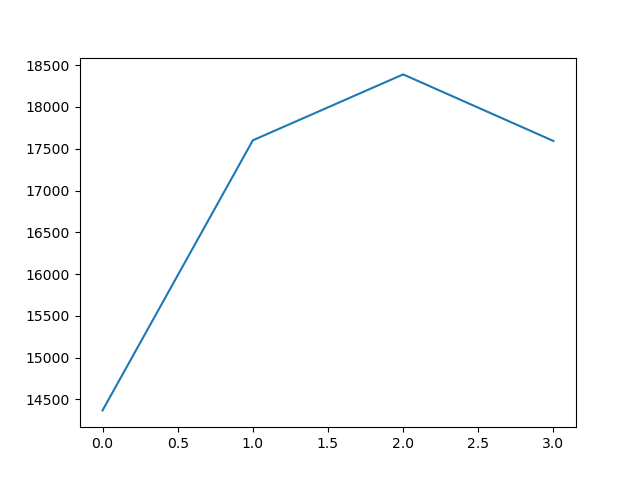

In [36]:
%matplotlib widget

plt.plot(modulation[5])

In [3]:
a = True

assert a == False, 'It should be'

AssertionError: It should be

In [341]:
a = np.histogram(np.arange(10),bins=[0,1,1,2,5])

In [347]:
a = sess.ripple.starts
b = sess.ripple.stops

np.all((a[1:]-b[:-1])>0)

True

In [ ]:
%matplotlib widget


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
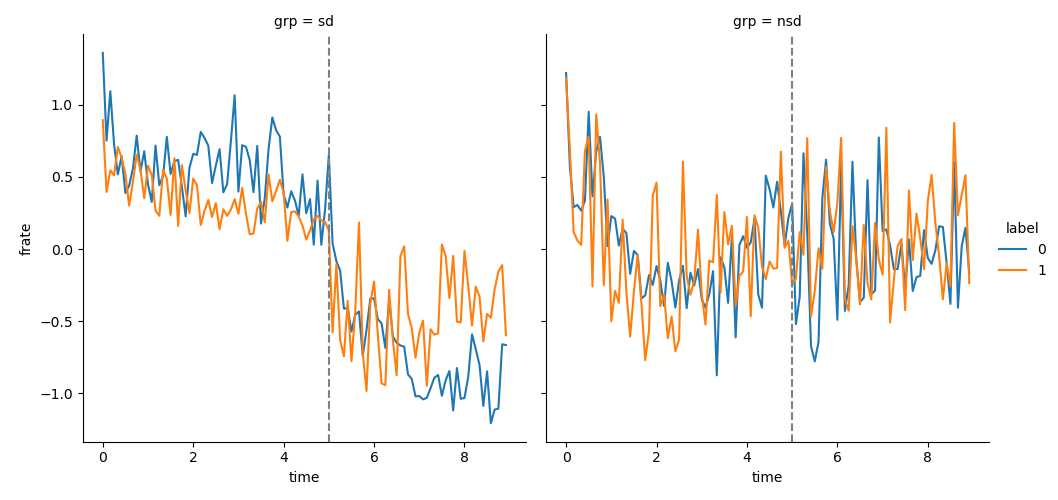

In [339]:
%matplotlib widget
import seaborn as sns

g = sns.relplot(
    data=frate_session_df,
    x="time",
    y="frate",
    hue="label",
    kind="line",
    ci=None,
    col="grp",
)

for ax in g.axes.reshape(-1):
    ax.axvline(5,ls='--',color='gray') 
